In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn import datasets
import sklearn
%matplotlib inline

torch.manual_seed(1)    # reproducible

In [2]:
def generate_data(N=80):
    r = np.linspace(0, 2,num=N)
    
    r1 = (2)*np.random.random_sample(N)
    r2 = (2)*np.random.random_sample(N)
    xTr1 = np.array([r1, np.power(r1,3)-2*np.square(r1)]).T
    xTr2 = np.array([r2, np.power(r2,3)-2*np.square(r2)-2.5+np.random.random_sample(N)]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

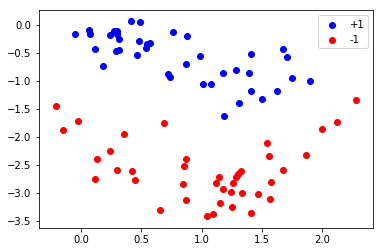

In [3]:
xTr,yTr,xTe,yTe=generate_data()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [4]:
def two_moons(N=10):
    x = sklearn.datasets.make_moons(n_samples=N, shuffle=False, noise=None, random_state=None)
    xTr = x[0]
    yTr = x[1]
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

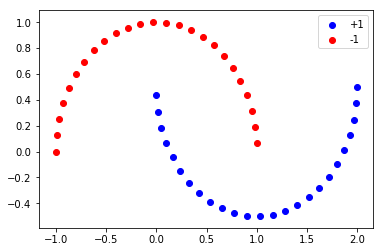

In [5]:
xTr,yTr,xTe,yTe=two_moons(100)
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [6]:
import densenet as dn

In [7]:
model = dn.DenseNet3(20, 2, 4, reduction=0.5,
                     bottleneck=True, dropRate=0)

In [8]:
#Not used yet

class BottleneckBlock(nn.Module):
    def __init__(self,in_planes,out_planes,dropRate=0.0):
        super(BottleneckBlock,self).__init__()
        self.linear(in_planes,out_planes)
        
class DenseBlock(nn.Module):
    def __init__(self,nb_layers,n_feature,growth_rate,block,dropRate):
        super(DenseBlock,self).__init__()
        self.layer = self._make_layer(nb_layers, in_planes, growth_rate, block, dropRate)

    def _make_layer(self,block,in_planes,growth_rate,nb_layers,dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate,growth_rate,dropRate))
        return nn.Sequential(*layers)
    def forward(self,x):
        return self.layer(x)
    
class DenseNet_lite(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(DenseNet_lite, self).__init__()
        
        block = BottleneckBlock
        self.block = DenseBlock(nb_layers,n_feature,growth_rate,block,dropRate)
        
        
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.out(x)
        return x

In [20]:
# torch can only train on Variable, so convert them to Variable
x = torch.from_numpy(xTr).float()
y = torch.from_numpy(yTr)
x = x.contiguous()
x = x.view(50,1,1,2)
x, y = Variable(x), Variable(y)

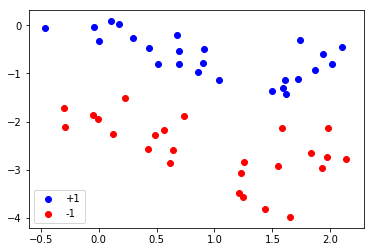

In [18]:
xTr,yTr,xTe,yTe=generate_data(50)
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

In [22]:
plt.ion() 
for t in range(100):
    out = model(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
#     print(loss.data)
    if t % 10 == 0 or t in [3, 6]:
        # plot and show learning process
        plt.cla()
        _, prediction = torch.max(F.softmax(out), 1)
        pred_y = prediction.data.numpy().squeeze()
        target_y = y.data.numpy()
        plt.scatter(x.view(-1,2).data.numpy()[:, 0], x.view(-1,2).data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y)/x.size()[0]
        plt.text(1.5, -1, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
        plt.show()
        plt.pause(0.1)

plt.ioff()


TypeError: FloatClassNLLCriterion_updateOutput received an invalid combination of arguments - got ([32;1mint[0m, [32;1mtorch.FloatTensor[0m, [31;1mtorch.DoubleTensor[0m, [32;1mtorch.FloatTensor[0m, [32;1mbool[0m, [32;1mNoneType[0m, [32;1mtorch.FloatTensor[0m, [32;1mint[0m), but expected (int state, torch.FloatTensor input, torch.LongTensor target, torch.FloatTensor output, bool sizeAverage, [torch.FloatTensor weights or None], torch.FloatTensor total_weight, int ignore_index)